In [1]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt 
import math

def get_frame(video_path, frame_number=0):
    vidcap = cv2.VideoCapture(video_path)
    count = 0
    success, image = vidcap.read()
    while success and count < frame_number:
        success, image = vidcap.read()
        count += 1
        
    if count < frame_number:
        raise RuntimeError('Frame number is too big for this video.')
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def cv_2_image(image):
    im_pil = Image.fromarray(image)
    return im_pil

def image_2_numpy(image):
    return np.asarray(image)

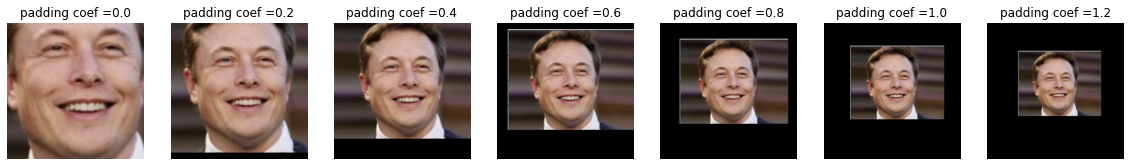

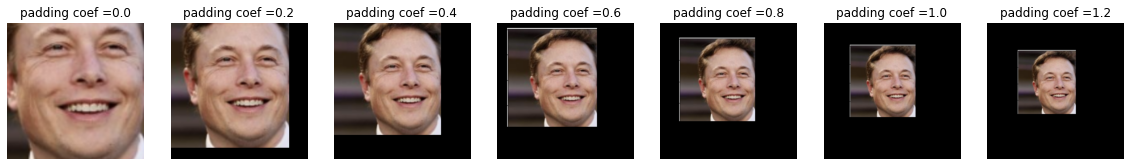

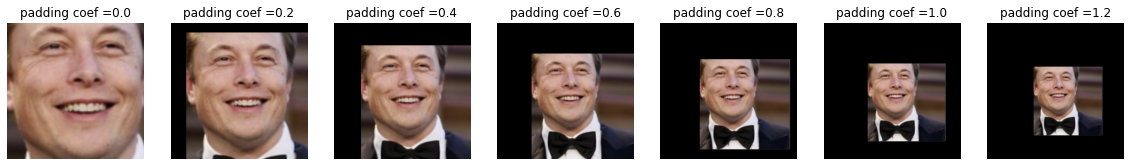

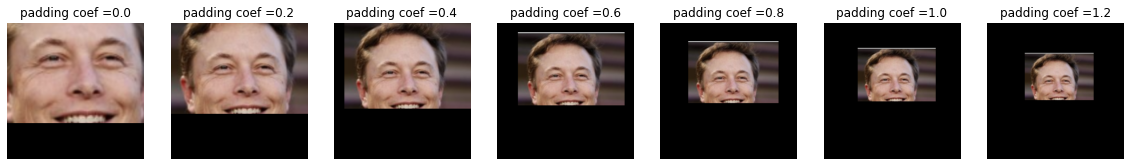

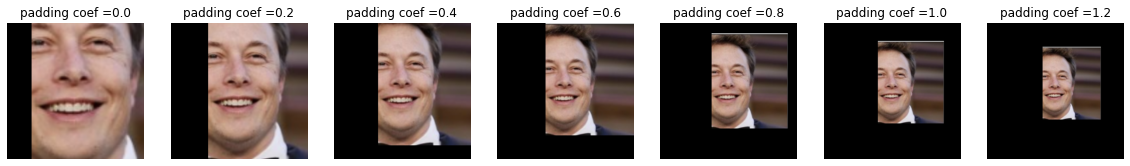

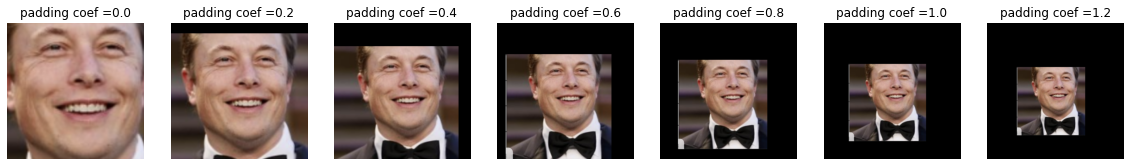

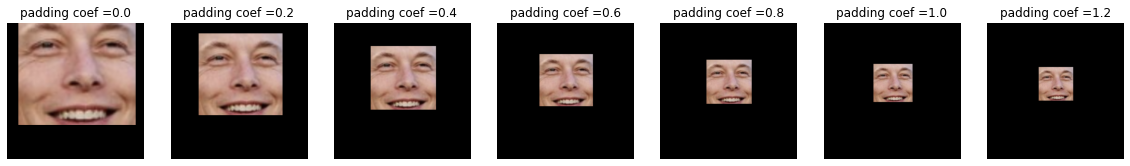

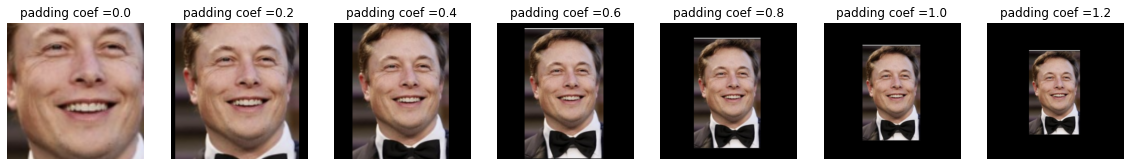

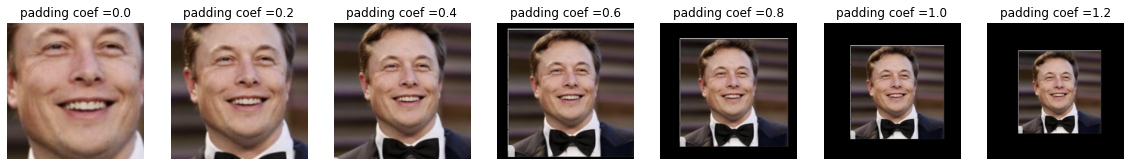

In [4]:
import face_alignment
from skimage import io
import PIL.Image
import copy


fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')

for j in range(9):
    image = PIL.Image.open(f'media/tests/elon-{j}.png')
    image = image.convert('RGB')
    image = image_2_numpy(image)
    preds = fa.get_landmarks(image)
        
    # найдем крайние точки
    x_min = int(min(preds[0][:, 0]))
    x_max = int(max(preds[0][:, 0]))
    y_min = int(min(preds[0][:, 1]))
    y_max = int(max(preds[0][:, 1]))

    # достроим до квадрата
    w = x_max - x_min
    h = y_max - y_min
    if w > h:
        y_max += (w - h) // 2
        y_min -= math.ceil((w - h) / 2)
    else:
        x_max += (h - w) // 2
        x_min -= math.ceil((h - w) / 2)
      
    fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(20, 5))
    for i in range(7):
        padding_x = int((x_max - x_min) * i / 10 * 2)
        padding_y = int((y_max - y_min) * i / 10 * 2)
        
        x_current_min = x_min - padding_x
        x_current_max = x_max + padding_x
        y_current_min = y_min - padding_y
        y_current_max = y_max + padding_y
        
        # обработаем выходы за границы
        l_x_pad, r_x_pad, u_y_pad, d_y_pad = 0, 0, 0, 0
        if x_current_min < 0:
            l_x_pad = -x_current_min
            x_current_min = 0
            x_current_max += l_x_pad
        if x_current_max > image.shape[1]:
            r_x_pad = x_current_max - image.shape[1]
        if y_current_min < 0:
            u_y_pad = -y_current_min
            y_current_min = 0
            y_current_max += u_y_pad
        if y_current_max > image.shape[0]:
            d_y_pad = y_current_max - image.shape[0]
        
        current_image = np.pad(array=image, pad_width=((u_y_pad, d_y_pad), (l_x_pad, r_x_pad), (0, 0)), mode='constant', constant_values=0)
        crop_img = current_image[y_current_min:y_current_max, x_current_min:x_current_max]
        assert crop_img.shape[0] == crop_img.shape[1] 
        
        axs[i].imshow(crop_img)
        axs[i].axis('off')
        axs[i].title.set_text('padding coef =' + str(i / 10 * 2))

## Rotation

In [36]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def rotateImage(image, angle):
    row, col = image.shape[:-1]
    center = tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    new_image = cv2.warpAffine(image, rot_mat, (col, row))
    return new_image

def rad_to_angel(rad):
    return rad / (2 * math.pi) * 360

In [52]:
import matplotlib.pyplot as plt
import face_alignment
from skimage import io

def rotate(image, detector):
    preds = detector.get_landmarks(image)
    detection = preds[0]
    A = np.array([detection[30,0], detection[30,1]])
    B = np.array([detection[8,0], detection[8,1]])
    C = np.array([detection[8,0], detection[30,1]])
    A = A - B
    B = C - B
    angle = rad_to_angel(angle_between(A, B))
    if A[0] < 0:
        angle = 360 - angle
    image = rotateImage(image, angle)
    return image

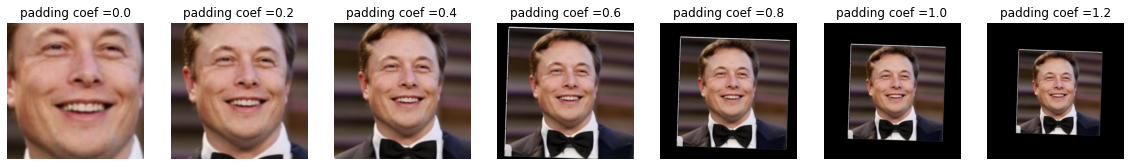

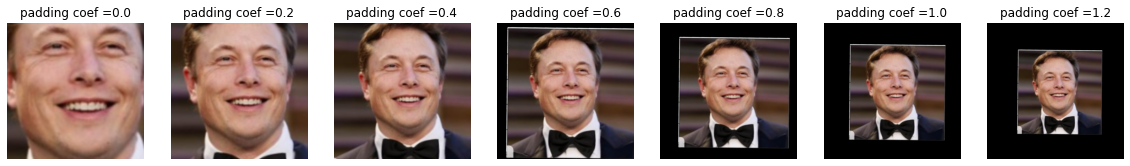

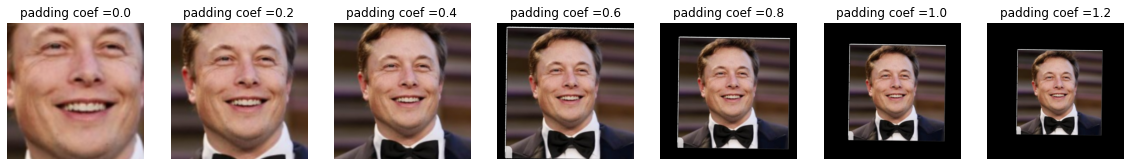

In [53]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')

for j in range(3):
    image = PIL.Image.open(f'media/tests-rotation/elon-{j}.png')
    image = image.convert('RGB')
    image = image_2_numpy(image)
    image = rotate(image, fa)
    preds = fa.get_landmarks(image)
        
    # найдем крайние точки
    x_min = int(min(preds[0][:, 0]))
    x_max = int(max(preds[0][:, 0]))
    y_min = int(min(preds[0][:, 1]))
    y_max = int(max(preds[0][:, 1]))

    # достроим до квадрата
    w = x_max - x_min
    h = y_max - y_min
    if w > h:
        y_max += (w - h) // 2
        y_min -= math.ceil((w - h) / 2)
    else:
        x_max += (h - w) // 2
        x_min -= math.ceil((h - w) / 2)
      
    fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(20, 5))
    for i in range(7):
        padding_x = int((x_max - x_min) * i / 10 * 2)
        padding_y = int((y_max - y_min) * i / 10 * 2)
        
        x_current_min = x_min - padding_x
        x_current_max = x_max + padding_x
        y_current_min = y_min - padding_y
        y_current_max = y_max + padding_y
        
        # обработаем выходы за границы
        l_x_pad, r_x_pad, u_y_pad, d_y_pad = 0, 0, 0, 0
        if x_current_min < 0:
            l_x_pad = -x_current_min
            x_current_min = 0
            x_current_max += l_x_pad
        if x_current_max > image.shape[1]:
            r_x_pad = x_current_max - image.shape[1]
        if y_current_min < 0:
            u_y_pad = -y_current_min
            y_current_min = 0
            y_current_max += u_y_pad
        if y_current_max > image.shape[0]:
            d_y_pad = y_current_max - image.shape[0]
        
        current_image = np.pad(array=image, pad_width=((u_y_pad, d_y_pad), (l_x_pad, r_x_pad), (0, 0)), mode='constant', constant_values=0)
        crop_img = current_image[y_current_min:y_current_max, x_current_min:x_current_max]
        assert crop_img.shape[0] == crop_img.shape[1] 
        
        axs[i].imshow(crop_img)
        axs[i].axis('off')
        axs[i].title.set_text('padding coef =' + str(i / 10 * 2))